In [1]:
! uv pip install -U langchain-tavily

Using Python 3.10.9 environment at: F:\code\ai\langgraph-learn\.venv
Resolved 43 packages in 1.86s
Audited 43 packages in 0.19ms


In [2]:
from dotenv import load_dotenv
load_dotenv()


True

## 定义Tool

In [3]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'LangGraph Basics: Understanding State, Schema, Nodes, and Edges',
   'url': 'https://medium.com/@vivekvjnk/langgraph-basics-understanding-state-schema-nodes-and-edges-77f2fd17cae5',
   'content': 'LangGraph Basics: Understanding State, Schema, Nodes, and Edges | by Story_Teller | Medium LangGraph Basics: Understanding State, Schema, Nodes, and Edges LangGraph Basics: Understanding State, Schema, Nodes, and Edges These predefined structures in the messaging app are synonymous with the schema of the state in LangGraph. Just as a messaging app ensures all interactions (messages) follow a consistent format, the schema in LangGraph ensures the state passed along edges is structured and interpretable. This static schema allows nodes to rely on a consistent state format, ensuring seamless communication along edges throughout the graph. In this article, we explored t

## 定义Graph

In [4]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [5]:
! uv pip install -U "langchain[openai]"

Using Python 3.10.9 environment at: F:\code\ai\langgraph-learn\.venv
Resolved 39 packages in 1.76s
Audited 39 packages in 0.22ms


### llm绑定tools
这一步是让llm知道有哪些工具可以使用

In [6]:
from langchain_openai import ChatOpenAI
import os

llm = ChatOpenAI(model="qwen-plus-latest",base_url="https://dashscope.aliyuncs.com/compatible-mode/v1", 
        api_key=os.getenv("DASHSCOPE_API_KEY"),
        temperature=0)

llm_with_tools = llm.bind_tools(tools)

In [7]:
def chatbot_node(state: State):
    return {"messages": llm_with_tools.invoke(state["messages"])}

graph_builder.add_node("chatbot", chatbot_node)

## 创建tool函数
graph中的运行单元都是一个node，以函数的形式存在，tool也不例外,所以要创建一个函数来运行这个tool。
为此langgraph的prebuilt包下封装了一个ToolNode

In [8]:
from langgraph.prebuilt import ToolNode

graph_builder.add_node("tools", ToolNode(tools=[tool]))

## 创建MemorySaver checkpointer

In [9]:
from langgraph.graph import END
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

## 可视化graph
您可以使用 get_graph 方法和其中一种“draw”方法（例如 draw_ascii 或 draw_png 来可视化图形。每种 draw 方法都需要额外的依赖项。

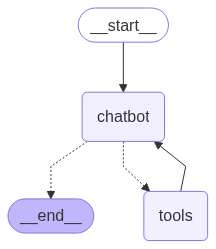

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## 运行chatbot

In [21]:
config = {
    "configurable": {
        "thread_id": "2",
    }
}

In [22]:
def stream_graph_updates(user_input: str):
    for event in graph.stream(
        {"messages": [{"role": "user", "content": user_input}]},
        config=config,
        stream_mode="values",
    ):
        messages = event["messages"]
        print(messages[-1].content if isinstance(messages, list) else messages.content)

In [23]:
stream_graph_updates("最新有哪些AI相关的新闻？")

最新有哪些AI相关的新闻？

{"query": "最新AI相关新闻", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://techxplore.com/news/2025-05-vision-mimic-human-precision.html", "title": "Self-trained vision transformers mimic human gaze with surprising precision - Tech Xplore", "score": 0.62879556, "published_date": "Mon, 26 May 2025 16:58:35 GMT", "content": "##### AI model pinpoints sources of driver stress, paving the way for smart driving assistants 2 hours ago ##### Tool automatically separates training and test data to improve AI evaluation 2 hours ago ##### Dark LLMs: It's still easy to trick most AI chatbots into providing harmful information, study finds 2 hours ago ##### Engineered interface layer extends life and enhances safety of next-generation lithium-metal batteries 3 hours ago ##### Exploring the seas with self-powered jellyfish cyborgs 4 hours ago ##### Golden Dome: An aerospace engineer explains the proposed nationwide missile defense system May 24, 2025 

In [20]:
stream_graph_updates("编写一个简单的示例demo")

编写一个简单的示例demo

{"query": "LangGraph 示例代码", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://blog.csdn.net/happyweb/article/details/138366645", "title": "简单的LangGraph示例原创 - CSDN博客", "content": "简单的LangGraph示例\n\n在学习智能体，然后又接触到LangGraph，参照文档尝试了一个简单的LangGraph demo。\n\n一、环境准备：\n\n二、代码：\n\n关于状态机、节点、边、有向无环图等概念可以去参照相关文档，在这里就不赘述了。\n\n上面代码添加了2个节点，其分别为agent和action，还添加了1个条件边。\n\n三、解释一下几个函数：\n\n3.1. add_node(key,action)：\n\n添加节点。节点是要做处理的。         key 是节点的名字，后面会根据这个名字去确定这个节点的。         action是一个函数或者一个LCEL runnable，这个函数或者 LCEL runnable 应该接收一个和状态对象一样的字典作为输入，         其输出也是以状态对象中的属性为key的一个字典，从而更新状态对象中对应的值。\n\n\n\n3.2. add_edge(start_key, end_key) [...] 在两个节点之间添加边(连线)，从前往后         start_key 开始节点的名字         end_key   结束节点的名字     3.3. add_conditional_edges(source, path, path_map=None, then=None)\n\n添加条件边         source (str) – 开始节点名         path (Union[Callable, Runnable]) – 决定下一个节点的回调函数         path_map (Optional[dict[str, str]], default: None ) – 映射下一个节点的字典.         